## 1. Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt
import re

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.metrics import silhouette_score , silhouette_samples, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import plotly.express as px
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set random seed untuk reprodusibilitas
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load Dataset

Dataset diambil dari GitHub repository sesuai ketentuan kompetisi.

In [2]:
#Load Dataset
url = 'https://raw.githubusercontent.com/micelll/SPARC-2026/main/SPARC_dataset.csv'
df = pd.read_csv(url)
df.head()

,Customer ID,Kelurahan,Kecamatan,Kode POS,Cash/Credit,Kode Dealer,Finance Company,Tenor,Gender,Tgl Lahir,...,range dp,wilayah,9 segment,kode motor,OTR,tahun rakit,DLR group,tgl cetak,tgl mohon,Kode Kota-Provinsi
0,CUST-159769,Baru Ilir,Balikpapan Barat,76131,2.0,12756.0,4,3,2,1992-03-03 0:00:00,...,2 - 3 juta,6471,AT LOW,HN,18685000.0,NaN,NaN,NaN,02-01-2019,6471-6400
1,CUST-164551,BARU TENGAH,BALIKPAPAN BARAT,76132,2.0,733.0,1,1,2,1991-04-27 0:00:00,...,3 jt up,6471,AT LOW,HN,18685000.0,NaN,NaN,NaN,02012019,6471-6400
2,CUST-159733,BARU TENGAH,BALIKPAPAN BARAT,76132,1.0,733.0,N,N,2,1982-01-04 0:00:00,...,kurang 1 juta,6471,AT MID,HR,20775000.0,NaN,NaN,NaN,02012019,6471-6400
3,CUST-164422,BARU TENGAH,BALIKPAPAN BARAT,76132,1.0,733.0,N,N,2,1997-06-26 0:00:00,...,krg 1 jt,6471,AT MID,HR,20775000.0,NaN,NaN,NaN,02012019,6471-6400
4,CUST-155472,Baru Ulu,Balikpapan Barat,76133,2.0,11160.0,1,2,1,1996-07-12 0:00:00,...,2 - 3 jt,6471,AT MID,HR,20775000.0,NaN,NaN,NaN,02-01-2019,6471-6400


Dataset mengandung 28 fitur sesuai data description:
- Fitur demografi (Gender, Agama, Pekerjaan, Umur, Tgl lahir )
- Fitur transaksi (DP Aktual, Cicilan, OTR, range dp, cash/credit, tenor)
- Fitur kendaraan (Tahun Rakit, Type Series, warna, 9 segment, kode motor)
- Fitur wilayah (wilayah, Kode Kota-Provinsi, Kecamatan, Kelurahan, Kode POS)
- Fitur tambahan (customer id, kode dealer, finance company, dealer, tgl cetak, tgl mohon, dlr group)

In [3]:
df.sample(5)

,Customer ID,Kelurahan,Kecamatan,Kode POS,Cash/Credit,Kode Dealer,Finance Company,Tenor,Gender,Tgl Lahir,...,range dp,wilayah,9 segment,kode motor,OTR,tahun rakit,DLR group,tgl cetak,tgl mohon,Kode Kota-Provinsi
130703,CUST-169565,KARANG JOANG,BALIKPAPAN UTARA,76127,2.0,11160.0,1,1,1,1975-06-17 0:00:00,...,3 jt up,6471,AT HIGH,LT,33460000.0,2022,NaN,NaN,31072022,6471-6400
68816,CUST-05057,DAMAI BARU,BALIKPAPAN SELATAN,76114,1.0,11160.0,N,N,N,1990-01-01 0:00:00,...,krg 1 juta,6471,SPORT LOW,EI,22070000.0,2020,NaN,NaN,30112020,6471-6400
248898,CUST-166964,BATU AMPAR,BALIKPAPAN UTARA,76136,2.0,12757.0,2,2,1,1995-05-06 0:00:00,...,3 juta up,6471,AT HIGH,LT,35700000.0,2024,NaN,NaN,29082024,6471-6400
313306,CUST-20485,KARANG ANYAR,TARAKAN BARAT,77111,1.0,13686.0,N,N,2,1995-08-20 0:00:00,...,krg 1 jt,6571.0,AT LOW,MO,22210000.0,2025,NaN,NaN,17112025,6571-6500
301313,CUST-197535,DAMAI BARU,BALIKPAPAN SELATAN,76114,2.0,11160.0,1,2,1,1988-04-05 0:00:00,...,3 juta up,6471.0,AT LOW,MO,16909000.0,2025,NaN,NaN,18082025,6471-6400


In [4]:
# Informasi umum dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319978 entries, 0 to 319977
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Customer ID         319964 non-null  object 
 1   Kelurahan           319962 non-null  object 
 2   Kecamatan           319963 non-null  object 
 3   Kode POS            319963 non-null  object 
 4   Cash/Credit         319963 non-null  float64
 5   Kode Dealer         319963 non-null  float64
 6   Finance Company     319889 non-null  object 
 7   Tenor               319942 non-null  object 
 8   Gender              319962 non-null  object 
 9   Tgl Lahir           319963 non-null  object 
 10  Agama               319963 non-null  object 
 11  Pekerjaan           319963 non-null  object 
 12  umur                319963 non-null  float64
 13  dp aktual           319234 non-null  object 
 14  cicilan             319276 non-null  object 
 15  warna               319963 non-nul

## Data Checking

In [5]:
# Cek persentase nilai yang hilang dari setiap fitur
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage

Customer ID            0.004375
Kelurahan              0.005000
Kecamatan              0.004688
Kode POS               0.004688
Cash/Credit            0.004688
Kode Dealer            0.004688
Finance Company        0.027814
Tenor                  0.011251
Gender                 0.005000
Tgl Lahir              0.004688
Agama                  0.004688
Pekerjaan              0.004688
umur                   0.004688
dp aktual              0.232516
cicilan                0.219390
warna                  0.004688
dealer                 0.004688
type series            0.004688
range dp               0.004688
wilayah                0.004688
9 segment              0.004688
kode motor             0.016876
OTR                    0.005938
tahun rakit            3.097713
DLR group             80.687110
tgl cetak             95.866591
tgl mohon              0.004375
Kode Kota-Provinsi     0.000000
dtype: float64

In [6]:
# Drop kolom tgl cetak dan DLR group karena missing value terlalu tinggi
df = df.drop('tgl cetak', axis=1, errors='ignore')
df = df.drop('DLR group', axis=1, errors='ignore')
df.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319978 entries, 0 to 319977
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Customer ID         319964 non-null  object 
 1   Kelurahan           319962 non-null  object 
 2   Kecamatan           319963 non-null  object 
 3   Kode POS            319963 non-null  object 
 4   Cash/Credit         319963 non-null  float64
 5   Kode Dealer         319963 non-null  float64
 6   Finance Company     319889 non-null  object 
 7   Tenor               319942 non-null  object 
 8   Gender              319962 non-null  object 
 9   Tgl Lahir           319963 non-null  object 
 10  Agama               319963 non-null  object 
 11  Pekerjaan           319963 non-null  object 
 12  umur                319963 non-null  float64
 13  dp aktual           319234 non-null  object 
 14  cicilan             319276 non-null  object 
 15  warna               319963 non-nul

In [7]:
#cek duplikasi data
df.duplicated().sum()

np.int64(2347)

In [8]:
# Drop duplikasi data 
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [9]:
# Cek persentase nilai yang hilang dari setiap fitur setelah drop kolom
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage

Customer ID           0.000315
Kelurahan             0.000944
Kecamatan             0.000630
Kode POS              0.000630
Cash/Credit           0.000630
Kode Dealer           0.000630
Finance Company       0.023612
Tenor                 0.007241
Gender                0.000944
Tgl Lahir             0.000630
Agama                 0.000630
Pekerjaan             0.000630
umur                  0.000630
dp aktual             0.220382
cicilan               0.207159
warna                 0.000630
dealer                0.000630
type series           0.000630
range dp              0.000630
wilayah               0.000630
9 segment             0.000630
kode motor            0.012908
OTR                   0.001889
tahun rakit           3.104231
tgl mohon             0.000315
Kode Kota-Provinsi    0.000000
dtype: float64

In [10]:
# Daftar kolom yang akan di-drop missing value-nya
cols_to_clean = [
    'Customer ID', 'Cash/Credit', 'Tenor', 'Gender', 'Tgl Lahir','Pekerjaan',
    'umur', 'dp aktual', 'cicilan', 'warna', 'type series',
    '9 segment', 'kode motor', 'OTR', 'tahun rakit', 'tgl mohon'
]

# Drop rows dengan missing value di kolom-kolom tersebut
df = df.dropna(subset=cols_to_clean) 

# Verifikasi
print(f"Jumlah baris setelah drop missing value: {len(df):,}")
print("\nMissing value per kolom:")
print(df[cols_to_clean].isnull().sum())

Jumlah baris setelah drop missing value: 307,101

Missing value per kolom:
Customer ID    0
Cash/Credit    0
Tenor          0
Gender         0
Tgl Lahir      0
Pekerjaan      0
umur           0
dp aktual      0
cicilan        0
warna          0
type series    0
9 segment      0
kode motor     0
OTR            0
tahun rakit    0
tgl mohon      0
dtype: int64


Capping umur berdasarkan domain

In [11]:
# ==============================================================================
# PEMBATASAN UMUR BERDASARKAN ATURAN DOMAIN (DOMAIN RULE BASED CAPPING)
# ==============================================================================
# Aturan bisnis:
# Dalam konteks pembiayaan / kredit kendaraan di Indonesia:
# - Usia minimum legal untuk mengajukan kredit adalah 17 tahun
# - Usia maksimum produktif / yang umumnya dapat diasuransikan adalah 65 tahun
#
# Perlakuan khusus:
# - umur == 0        → kesalahan input absolut (tidak mungkin) → ubah menjadi NaN
# - umur < 17        → tidak memenuhi syarat hukum kredit → ubah menjadi NaN
# - umur > 65        → di luar usia produktif → dibatasi (cap) menjadi 65
#
# Catatan:
# Tidak dilakukan transformasi log karena distribusi umur umumnya
# mendekati normal / tidak memiliki skew ekstrem seperti variabel finansial.
# ==============================================================================

# Pastikan kolom umur bertipe numerik
df['umur'] = pd.to_numeric(df['umur'], errors='coerce')

# Tentukan batas usia legal
AGE_MIN = 17
AGE_MAX = 65

# ==============================================================================
# VALIDASI SEBELUM CAPPING
# ==============================================================================
print("="*80)
print("SEBELUM CAPPING USIA")
print("="*80)
print(f"Umur min: {df['umur'].min()}")
print(f"Umur max: {df['umur'].max()}")
print(f"Umur > 65: {(df['umur'] > AGE_MAX).sum():,}")
print(f"Umur < 17: {(df['umur'] < AGE_MIN).sum():,}")
print(f"Umur == 0: {(df['umur'] == 0).sum():,}")

# ==============================================================================
# DOMAIN RULE BASED CAPPING (MODIFY IN PLACE)
# ==============================================================================

# umur == 0 → NaN
df.loc[df['umur'] == 0, 'umur'] = np.nan

# umur < 17 → NaN
df.loc[df['umur'] < AGE_MIN, 'umur'] = np.nan

# umur > 65 → cap menjadi 65
df.loc[df['umur'] > AGE_MAX, 'umur'] = AGE_MAX

# ==============================================================================
# VALIDASI SETELAH CAPPING
# ==============================================================================
print("\n" + "="*80)
print("SETELAH CAPPING USIA")
print("="*80)
print(f"Umur min: {df['umur'].min()}")
print(f"Umur max: {df['umur'].max()}")
print(f"Umur > 65: {(df['umur'] > AGE_MAX).sum():,}")
print(f"Umur < 17: {(df['umur'] < AGE_MIN).sum():,}")
print(f"Umur NaN: {df['umur'].isna().sum():,}")

SEBELUM CAPPING USIA
Umur min: 0.0
Umur max: 1230.0
Umur > 65: 59,564
Umur < 17: 309
Umur == 0: 192

SETELAH CAPPING USIA
Umur min: 17.0
Umur max: 65.0
Umur > 65: 0
Umur < 17: 0
Umur NaN: 309


### Cleaning DP Aktual dan Cicilan

Membersihkan format rupiah yang tidak konsisten: "Rp 0", "Rp 6000", "0", "6000"

In [12]:
df['dp aktual'].unique()

array(['250000000', '42000000', 'Rp 25.000.000', ..., '8878272',
       '1061922', '1757000'], shape=(6831,), dtype=object)

In [13]:
# Tampilkan semua nilai unik tanpa truncation
np.set_printoptions(threshold=np.inf) 
unique_values = df['dp aktual'].unique()
print(f"Total nilai unik: {len(unique_values)}")

Total nilai unik: 6831


In [14]:
# menyimpan nilai asli sebelum transformasi
df['dp_aktual_raw'] = df['dp aktual']
df['cicilan_raw'] = df['cicilan']

In [15]:
# Fungsi untuk membersihkan format rupiah dan mengubahnya menjadi numerik
def clean_rupiah(series):
    s = (
        series
        .astype(str)
        .str.upper()
        .str.replace('RP', '', regex=False)
        .str.replace(r'[^\d]', '', regex=True)
        .replace('', np.nan)
    )
    s = pd.to_numeric(s, errors='coerce')
    s.loc[s <= 0] = np.nan
    return s

df['dp aktual'] = clean_rupiah(df['dp aktual'])
df['cicilan'] = clean_rupiah(df['cicilan'])

df[['dp aktual', 'cicilan']].describe()

,dp aktual,cicilan
count,1.751690e+05,1.751650e+05
mean,2.758664e+07,1.399262e+07
std,7.845423e+07,4.269778e+08
min,1.000000e+00,1.000000e+00
25%,4.000000e+06,1.720000e+06
50%,2.000000e+07,1.200000e+07
75%,3.600000e+07,1.500000e+07
max,3.000000e+10,8.575233e+10


In [16]:
df[['dp aktual', 'cicilan']].head()

,dp aktual,cicilan
9882,250000000.0,12000000.0
9883,42000000.0,18320000.0
9884,25000000.0,15100000.0
9885,25000000.0,15000000.0
9886,145000000.0,33500000.0


Identifikasi currency anomaly

In [17]:
# =============================================================================
# BUSINESS RULE UNTUK dp aktual & cicilan
#
# Rule A — Anomali Logis:
# Transaksi kredit (Cash_Credit_enc == 1) TIDAK BOLEH memiliki
# dp aktual = 0 atau cicilan = 0.
# Karena produk kredit pasti memiliki DP dan cicilan.
# Jika terjadi, maka dianggap tidak memiliki sinyal finansial → set menjadi NaN.
#
# Rule B — Pembatasan Nilai Maksimum (Typo Cap):
# dp aktual dan cicilan TIDAK MUNGKIN melebihi harga OTR kendaraan.
# Jika lebih besar dari OTR → kemungkinan salah input (kelebihan nol, dll).
# Maka nilai dibatasi maksimal sebesar OTR pada baris tersebut.
#
# Rule C — Transformasi log1p:
# Fitur berbasis nominal uang biasanya sangat right-skewed.
# log1p digunakan untuk:
# - Mengompresi rentang nilai
# - Aman untuk nilai nol (log1p(0) = 0)
# - Menstabilkan jarak untuk clustering berbasis distance
# =============================================================================

# -----------------------------------------------------------------------------
# RULE A — Kredit dengan dp atau cicilan = 0 → NaN
# -----------------------------------------------------------------------------
is_credit = df['Cash/Credit'] == 2

df.loc[is_credit & (df['dp aktual'] == 0), 'dp aktual'] = np.nan
df.loc[is_credit & (df['cicilan']   == 0), 'cicilan']   = np.nan

# -----------------------------------------------------------------------------
# RULE B — Batasi dp aktual & cicilan maksimal sebesar OTR
# -----------------------------------------------------------------------------
df.loc[df['dp aktual'] > df['OTR'], 'dp aktual'] = df['OTR']
df.loc[df['cicilan']   > df['OTR'], 'cicilan']   = df['OTR']

# -----------------------------------------------------------------------------
# RULE C — Transformasi log1p untuk mengurangi skewness
# -----------------------------------------------------------------------------
df['dp aktual'] = np.log1p(df['dp aktual'])
df['cicilan']   = np.log1p(df['cicilan'])

df[['Cash/Credit','dp aktual', 'cicilan']].sample(5)

,Cash/Credit,dp aktual,cicilan
196576,2.0,17.727534,16.540746
186447,1.0,NaN,NaN
197736,1.0,NaN,NaN
34877,1.0,NaN,NaN
306083,1.0,NaN,NaN


### Standardisasi Format Tanggal (tgl mohon)

Menggunakan regex untuk menangani format tanggal yang tidak konsisten:
- Format 1: `02-01-2019` (dengan separator)
- Format 2: `02012019` (tanpa separator)

In [18]:
def standardize_date(date_str):
    if pd.isna(date_str):
        return np.nan
    
    date_str = str(date_str).strip()
    
    # Jika string kosong, return NaN
    if date_str == '' or date_str.lower() == 'nan':
        return np.nan
    
    # PENTING: Strip timestamp jika ada (spasi dan setelahnya)
    # "1992-03-03 0:00:00" → "1992-03-03"
    date_str = re.sub(r'\s+.*$', '', date_str)
    
    def validate_date(dd, mm, yyyy):
        """Validasi apakah tanggal valid"""
        try:
            dd_int = int(dd)
            mm_int = int(mm)
            yyyy_int = int(yyyy)
            
            # Validasi range
            if dd_int < 1 or dd_int > 31:
                return False
            if mm_int < 1 or mm_int > 12:
                return False
            if yyyy_int < 1900 or yyyy_int > 2026:
                return False
            
            return True
        except:
            return False
    
    # Pattern 1: DDMMYYYY (HARUS 8 digit, tidak lebih tidak kurang) -> DD-MM-YYYY
    pattern1 = re.match(r'^(\d{2})(\d{2})(\d{4})$', date_str)
    if pattern1:
        dd, mm, yyyy = pattern1.groups()
        if validate_date(dd, mm, yyyy):
            return f"{dd}-{mm}-{yyyy}"
        else:
            return np.nan
    
    # Pattern 2: DD/MM/YYYY atau DD-MM-YYYY atau DD.MM.YYYY -> DD-MM-YYYY
    pattern2 = re.match(r'^(\d{1,2})[-/.](\d{1,2})[-/.](\d{4})$', date_str)
    if pattern2:
        dd, mm, yyyy = pattern2.groups()
        if validate_date(dd, mm, yyyy):
            return f"{dd.zfill(2)}-{mm.zfill(2)}-{yyyy}"
        else:
            return np.nan
    
    # Pattern 3: YYYY-MM-DD atau YYYY/MM/DD -> DD-MM-YYYY
    pattern3 = re.match(r'^(\d{4})[-/.](\d{1,2})[-/.](\d{1,2})$', date_str)
    if pattern3:
        yyyy, mm, dd = pattern3.groups()
        if validate_date(dd, mm, yyyy):
            return f"{dd.zfill(2)}-{mm.zfill(2)}-{yyyy}"
        else:
            return np.nan
    
    # Pattern 4: DD-MMM-YYYY (e.g., 02-Jan-2019)
    pattern4 = re.match(r'^(\d{1,2})[-/.]([A-Za-z]{3})[-/.](\d{4})$', date_str)
    if pattern4:
        dd, mmm, yyyy = pattern4.groups()
        month_map = {
            'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04',
            'may': '05', 'jun': '06', 'jul': '07', 'aug': '08',
            'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
        }
        mm = month_map.get(mmm.lower(), '01')
        if validate_date(dd, mm, yyyy):
            return f"{dd.zfill(2)}-{mm}-{yyyy}"
        else:
            return np.nan
    
    # Jika tidak match pattern apapun atau tidak valid, return NaN (bukan original)
    # Data anomali seperti "319977" akan jadi NaN
    return np.nan

df_clean = df.copy() # Agar tidak merusak dataframe df

# Standardisasi tgl mohon
before_missing = df_clean['tgl mohon'].isna().sum()

# Terapkan standardisasi
df_clean['tgl mohon'] = df_clean['tgl mohon'].apply(standardize_date)

# Verifikasi sample hasil
print(df_clean['tgl mohon'].dropna().head(20).tolist())

# Cek apakah ada format yang tidak terstandarisasi
non_standard = df_clean['tgl mohon'].dropna()
non_standard = non_standard[~non_standard.str.match(r'^\d{2}-\d{2}-\d{4}$', na=False)]
if len(non_standard) > 0:
    print(f"\n⚠️  Ditemukan {len(non_standard):,} format yang tidak terstandarisasi:")
    print(non_standard.unique()[:10])
else:
    print("Semua format tgl mohon berhasil distandarisasi ke DD-MM-YYYY")

# Standardisasi Tgl Lahir 
print("\nStandardisasi Tgl Lahir")
df_clean['Tgl Lahir'] = df_clean['Tgl Lahir'].apply(standardize_date)
after_missing_lahir = df_clean['Tgl Lahir'].isna().sum()
print(f"✓ Sample: {df_clean['Tgl Lahir'].dropna().head(5).tolist()}")


['01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019', '01-04-2019']
Semua format tgl mohon berhasil distandarisasi ke DD-MM-YYYY

Standardisasi Tgl Lahir
✓ Sample: ['03-10-1982', '26-02-1990', '05-09-1983', '03-01-1989', '20-04-1981']


In [19]:
# Cek apakah ada format dan nilai yang belum ter-handle
df_clean.head()

,Customer ID,Kelurahan,Kecamatan,Kode POS,Cash/Credit,Kode Dealer,Finance Company,Tenor,Gender,Tgl Lahir,...,range dp,wilayah,9 segment,kode motor,OTR,tahun rakit,tgl mohon,Kode Kota-Provinsi,dp_aktual_raw,cicilan_raw
9882,CUST-255518,Babulu Darat,Babulu,76285,2.0,12242.0,2,1,1,03-10-1982,...,3 jt up,6409,AT HIGH,HV,34750000.0,2019.0,01-04-2019,6409-6400,250000000,12000000
9883,CUST-164345,Baru Ilir,Balikpapan Barat,76131,2.0,11160.0,4,2,1,26-02-1990,...,3 juta up,6471,AT HIGH,HU,31400000.0,2019.0,01-04-2019,6471-6400,42000000,18320000
9884,CUST-162851,Baru Ulu,Balikpapan Barat,76133,2.0,12757.0,1,2,2,05-09-1983,...,2 - 3 jt,6471,AT MID,HR,21025000.0,2019.0,01-04-2019,6471-6400,Rp 25.000.000,Rp 15.100.000
9885,CUST-265242,KARIANGAU,BALIKPAPAN BARAT,76134,2.0,733.0,1,2,2,03-01-1989,...,2 - 3 jt,6471,AT MID,HR,21025000.0,2019.0,01-04-2019,6471-6400,25000000,15000000
9886,CUST-163218,Klandasan Ilir,Balikpapan Kota,76113,2.0,12756.0,1,1,2,20-04-1981,...,3 juta up,6471,AT HIGH,HU,31400000.0,2019.0,01-04-2019,6471-6400,Rp 145.000.000,Rp 33.500.000


In [20]:
df.shape

(307101, 28)

## Konversi Tipe Data

Setelah cleaning, data siap dikonversi ke tipe data yang sesuai.

In [21]:
# String/Categorical columns
cols_str = [
    "Customer ID", "Kelurahan", "Kecamatan", "Kode POS", "Cash/Credit", "Kode Dealer", "Finance Company",
    "Gender", "Agama", "Pekerjaan", "warna", "dealer", "type series", 
    "range dp", "wilayah", "9 segment", "kode motor", 
    "Kode Kota-Provinsi"
]

# Numeric columns
cols_num = [
    "umur", "Tenor", "dp aktual", "cicilan", "OTR", "tahun rakit"
]

# Date columns
cols_date = [
    "Tgl Lahir", "tgl mohon"  # tgl cetak sudah di-drop
]

# Apply transformations dengan error handling
df_clean[cols_str] = df_clean[cols_str].astype("string")
df_clean[cols_num] = df_clean[cols_num].apply(pd.to_numeric, errors="coerce")
# Konversi datetime 
df_clean[cols_date] = df_clean[cols_date].apply(pd.to_datetime, format='%d-%m-%Y', errors="coerce")


In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307101 entries, 9882 to 319976
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Customer ID         307101 non-null  string        
 1   Kelurahan           307100 non-null  string        
 2   Kecamatan           307101 non-null  string        
 3   Kode POS            307101 non-null  string        
 4   Cash/Credit         307101 non-null  string        
 5   Kode Dealer         307101 non-null  string        
 6   Finance Company     307037 non-null  string        
 7   Tenor               174577 non-null  float64       
 8   Gender              307101 non-null  string        
 9   Tgl Lahir           307075 non-null  datetime64[ns]
 10  Agama               307101 non-null  string        
 11  Pekerjaan           307101 non-null  string        
 12  umur                306792 non-null  float64       
 13  dp aktual           175169 non-

In [23]:
#Cek missing value setelah transformasi
missing_percentage = (df_clean.isnull().sum() / len(df)) * 100
missing_percentage

Customer ID            0.000000
Kelurahan              0.000326
Kecamatan              0.000000
Kode POS               0.000000
Cash/Credit            0.000000
Kode Dealer            0.000000
Finance Company        0.020840
Tenor                 43.153230
Gender                 0.000000
Tgl Lahir              0.008466
Agama                  0.000000
Pekerjaan              0.000000
umur                   0.100618
dp aktual             42.960459
cicilan               42.961762
warna                  0.000000
dealer                 0.000000
type series            0.000000
range dp               0.000000
wilayah                0.000000
9 segment              0.000000
kode motor             0.000000
OTR                    0.000000
tahun rakit            0.033539
tgl mohon             31.521552
Kode Kota-Provinsi     0.000000
dp_aktual_raw          0.000000
cicilan_raw            0.000000
dtype: float64

In [24]:
#drop missing value
critical_cols = ['tgl mohon', 'tahun rakit', 'Tgl Lahir', 'umur']   # tambah kalau perlu
df_clean = df_clean.dropna(subset=critical_cols)
df_clean.isna().sum()

Customer ID               0
Kelurahan                 1
Kecamatan                 0
Kode POS                  0
Cash/Credit               0
Kode Dealer               0
Finance Company          62
Tenor                 90942
Gender                    0
Tgl Lahir                 0
Agama                     0
Pekerjaan                 0
umur                      0
dp aktual             90549
cicilan               90553
warna                     0
dealer                    0
type series               0
range dp                  0
wilayah                   0
9 segment                 0
kode motor                0
OTR                       0
tahun rakit               0
tgl mohon                 0
Kode Kota-Provinsi        0
dp_aktual_raw             0
cicilan_raw               0
dtype: int64

In [25]:
#cek jumlah baris data
print(f"Jumlah baris data setelah cleaning: {len(df_clean):,}")

Jumlah baris data setelah cleaning: 209,919


### Agregasi data berdasarkan Customer ID untuk menyelesaikan permasalahan duplikat

In [26]:
# Mengecek jumlah total duplikasi Customer ID
duplicate_count = df_clean['Customer ID'].duplicated().sum()

print("Jumlah Customer ID duplikat:")
print(duplicate_count)

Jumlah Customer ID duplikat:
25547


In [27]:
# Pastikan kolom 'tgl mohon' dan 'Tgl Lahir' bertipe datetime
df_clean['tgl mohon'] = pd.to_datetime(df_clean['tgl mohon'], format='%d-%m-%Y', dayfirst=True, errors='coerce')
df_clean['Tgl Lahir'] = pd.to_datetime(df_clean['Tgl Lahir'], format='%d-%m-%Y', dayfirst=True, errors='coerce')

# Urutkan dataset berdasarkan Tgl Mohon ascending
df_clean = df_clean.sort_values('tgl mohon', ascending=True).reset_index(drop=True)

# Tentukan tanggal terbaru dalam dataset untuk perhitungan Recency
max_date = df_clean['tgl mohon'].max()

# Grouping dan buat fitur Recency
recency = df_clean.groupby('Customer ID').agg({
    'tgl mohon': ['max', 'count']
}).reset_index()
recency.columns = ['Customer ID', 'last_tgl_mohon', 'frequency_purchase']

# Jika max_date adalah NaT (tidak ada tanggal valid), isi Recency dengan NaN, 
# jika tidak, hitung selisih hari
if pd.isna(max_date):
    recency['Recency'] = np.nan
else:
    # pastikan last_tgl_mohon bertipe datetime sebelum pengurangan
    recency['last_tgl_mohon'] = pd.to_datetime(recency['last_tgl_mohon'], errors='coerce')
    recency['Recency'] = (max_date - recency['last_tgl_mohon']).dt.days

# Agregasi untuk 13 fitur dengan ketentuan 'last'
aggregation_dict = {
    'Cash/Credit': 'last',
    'Tenor': 'last',
    'Gender': 'last',
    'Tgl Lahir': 'last',
    'Pekerjaan': 'last',
    'umur': 'last',
    'dp aktual': 'last',
    'cicilan': 'last',
    'warna': 'last',
    'type series': 'last',
    '9 segment': 'last',
    'kode motor': 'last',
    'OTR': 'last',
    'tgl mohon': 'last',
    'tahun rakit': 'last'
}

df_agg = df_clean.groupby('Customer ID', as_index=False).agg(aggregation_dict)

# Buat fitur Total_Monetary_Value (sum OTR per customer)
total_monetary = df_clean.groupby('Customer ID')['OTR'].sum().reset_index(name='Total_Monetary_Value')

# Merge fitur baru (Recency, Frequency_Purchase, Total_Monetary_Value)
df_agg = df_agg.merge(recency[['Customer ID', 'Recency', 'frequency_purchase']], 
                      on='Customer ID', how='left')
df_agg = df_agg.merge(total_monetary, on='Customer ID', how='left')

# Verifikasi hasil agregasi
print("="*80)
print("HASIL AGREGASI DATA")
print("="*80)
print(f"\nTotal customer unik (sebelum agregasi): {df_clean['Customer ID'].nunique():,}")
print(f"Total baris (sebelum agregasi): {len(df_clean):,}")
print(f"\nTotal customer unik (setelah agregasi): {len(df_agg):,}")
print(f"Total baris (setelah agregasi): {len(df_agg):,}")

# Validasi: tidak ada duplikat
print(f"\nDuplikat Customer ID setelah agregasi: {df_agg['Customer ID'].duplicated().sum()}")

# Info shape dan kolom
print(f"\nShape dataframe agregasi: {df_agg.shape}")
print(f"\nKolom-kolom:")
print(df_agg.columns.tolist())

# Sample data
print("\n" + "="*80)
print("SAMPLE DATA (5 baris pertama)")
print("="*80)
display(df_agg.head())

# Statistik fitur baru
print("\n" + "="*80)
print("STATISTIK FITUR BARU (RFM)")
print("="*80)
print(f"\nRecency (hari):")
print(df_agg['Recency'].describe())
print(f"\nFrequency_Purchase (jumlah transaksi):")
print(df_agg['frequency_purchase'].describe())
print(f"\nTotal_Monetary_Value (Rp):")
print(df_agg['Total_Monetary_Value'].describe())

HASIL AGREGASI DATA

Total customer unik (sebelum agregasi): 184,372
Total baris (sebelum agregasi): 209,919

Total customer unik (setelah agregasi): 184,372
Total baris (setelah agregasi): 184,372

Duplikat Customer ID setelah agregasi: 0

Shape dataframe agregasi: (184372, 19)

Kolom-kolom:
['Customer ID', 'Cash/Credit', 'Tenor', 'Gender', 'Tgl Lahir', 'Pekerjaan', 'umur', 'dp aktual', 'cicilan', 'warna', 'type series', '9 segment', 'kode motor', 'OTR', 'tgl mohon', 'tahun rakit', 'Recency', 'frequency_purchase', 'Total_Monetary_Value']

SAMPLE DATA (5 baris pertama)


,Customer ID,Cash/Credit,Tenor,Gender,Tgl Lahir,Pekerjaan,umur,dp aktual,cicilan,warna,type series,9 segment,kode motor,OTR,tgl mohon,tahun rakit,Recency,frequency_purchase,Total_Monetary_Value
0,CUST-00001,2.0,1.0,2,1981-12-15,4f,40.0,16.949482,16.341239,HM,SCOOTY SERIES,AT MID,LP,22965000.0,2021-05-17,2021.0,1689,1,2.296500e+07
1,CUST-00002,1.0,NaN,N,2000-02-01,N,22.0,NaN,NaN,PH,KRF150L,SPORT MID,EU,36120000.0,2022-02-25,2022.0,1405,20,5.159000e+08
2,CUST-00003,1.0,NaN,1,1991-04-10,11,28.0,NaN,NaN,BK,VAREX 150,AT HIGH,HY,25785000.0,2019-04-11,2019.0,2456,9,2.320650e+08
3,CUST-00004,1.0,NaN,N,2004-10-01,N,21.0,NaN,NaN,BK,SCOOTY SERIES,AT MID,MU,25200000.0,2025-12-01,2025.0,30,1,2.520000e+07
4,CUST-00005,1.0,NaN,N,1990-03-01,N,65.0,NaN,NaN,BK,AVD 160,AT HIGH,MC,380700000.0,2023-06-14,2023.0,931,9,1.279400e+09



STATISTIK FITUR BARU (RFM)

Recency (hari):
count    184372.000000
mean       1103.729574
std         758.974835
min           0.000000
25%         398.000000
50%        1038.000000
75%        1720.000000
max        2466.000000
Name: Recency, dtype: float64

Frequency_Purchase (jumlah transaksi):
count    184372.000000
mean          1.138562
std           0.876505
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         123.000000
Name: frequency_purchase, dtype: float64

Total_Monetary_Value (Rp):
count    1.843720e+05
mean     6.794836e+07
std      1.077494e+08
min      0.000000e+00
25%      2.127500e+07
50%      2.466000e+07
75%      3.918000e+07
max      9.146607e+09
Name: Total_Monetary_Value, dtype: float64


Validasi umur pembelian

In [28]:
# ================================================================
# AUTO-CORRECT UMUR BERDASARKAN Tgl Lahir DAN tgl mohon
# ================================================================

# Pastikan datetime
df_agg['Tgl Lahir'] = pd.to_datetime(df_agg['Tgl Lahir'], errors='coerce')
df_agg['tgl mohon'] = pd.to_datetime(df_agg['tgl mohon'], errors='coerce')

# Bersihkan DOB tidak masuk akal (future date atau terlalu tua >120 tahun)
today = pd.Timestamp.today()

df_agg.loc[df_agg['Tgl Lahir'] > today, 'Tgl Lahir'] = pd.NaT
df_agg.loc[
    (today - df_agg['Tgl Lahir']).dt.days / 365.25 > 120,
    'Tgl Lahir'
] = pd.NaT

# Pilih DOB terbaik per Customer (mode → paling sering muncul)
dob_mode = (
    df_agg
    .dropna(subset=['Customer ID', 'Tgl Lahir'])
    .groupby(['Customer ID', 'Tgl Lahir'])
    .size()
    .reset_index(name='freq')
)

# Ambil DOB dengan frekuensi tertinggi per customer
idx = dob_mode.groupby('Customer ID')['freq'].idxmax()
df_best_dob = dob_mode.loc[idx, ['Customer ID', 'Tgl Lahir']]

print(f"Total Customer dengan DOB final: {len(df_best_dob):,}")

# Replace Tgl Lahir di seluruh transaksi
df_agg = df_agg.drop(columns=['Tgl Lahir'], errors='ignore')

df_agg = df_agg.merge(
    df_best_dob,
    on='Customer ID',
    how='left'
)

# Hitung ulang umur sesungguhnya per transaksi
df_agg['umur_seharusnya'] = np.floor(
    (df_agg['tgl mohon'] - df_agg['Tgl Lahir']).dt.days / 365.25
)

# Tandai baris yang dikoreksi
df_agg['umur_dikoreksi_flag'] = np.where(
    df_agg['umur'] != df_agg['umur_seharusnya'],
    1,
    0
)

# Override umur lama dengan umur sesungguhnya
df_agg['umur'] = df_agg['umur_seharusnya']

# Optional: capping domain rule
AGE_MIN = 17
AGE_MAX = 65

df_agg.loc[df_agg['umur'] < AGE_MIN, 'umur'] = np.nan
df_agg.loc[df_agg['umur'] > AGE_MAX, 'umur'] = AGE_MAX

# Ringkasan hasil
print("\nRingkasan Koreksi:")
print(f"Total transaksi: {len(df_agg):,}")
print(f"Total umur dikoreksi: {df_agg['umur_dikoreksi_flag'].sum():,}")
print(f"Umur NaN setelah koreksi: {df_agg['umur'].isna().sum():,}")

Total Customer dengan DOB final: 184,316

Ringkasan Koreksi:
Total transaksi: 184,372
Total umur dikoreksi: 99,433
Umur NaN setelah koreksi: 68


In [29]:
df_agg.isna().sum()

Customer ID                 0
Cash/Credit                 0
Tenor                   77332
Gender                      0
Pekerjaan                   0
umur                       68
dp aktual               76994
cicilan                 76998
warna                       0
type series                 0
9 segment                   0
kode motor                  0
OTR                         0
tgl mohon                   0
tahun rakit                 0
Recency                     0
frequency_purchase          0
Total_Monetary_Value        0
Tgl Lahir                  56
umur_seharusnya            56
umur_dikoreksi_flag         0
dtype: int64

In [30]:
df_agg = df_agg.dropna(subset=['Tgl Lahir'])

In [31]:
df_agg.isna().sum()

Customer ID                 0
Cash/Credit                 0
Tenor                   77295
Gender                      0
Pekerjaan                   0
umur                       12
dp aktual               76958
cicilan                 76962
warna                       0
type series                 0
9 segment                   0
kode motor                  0
OTR                         0
tgl mohon                   0
tahun rakit                 0
Recency                     0
frequency_purchase          0
Total_Monetary_Value        0
Tgl Lahir                   0
umur_seharusnya             0
umur_dikoreksi_flag         0
dtype: int64

In [32]:
# Tampilkan sample data setelah capping
df_agg.sample(10)

,Customer ID,Cash/Credit,Tenor,Gender,Pekerjaan,umur,dp aktual,cicilan,warna,type series,...,kode motor,OTR,tgl mohon,tahun rakit,Recency,frequency_purchase,Total_Monetary_Value,Tgl Lahir,umur_seharusnya,umur_dikoreksi_flag
131777,CUST-265291,1.0,NaN,1,4f,41.0,NaN,NaN,BR,VEXA SERIES,...,EI,22320000.0,2019-08-31,2019.0,2314,1,22320000.0,1978-01-07,41.0,0
122419,CUST-252784,2.0,2.0,1,5,21.0,15.424949,14.428532,WH,SCOOTY SERIES,...,MU,25920000.0,2025-10-22,2025.0,70,1,25920000.0,2004-03-23,21.0,0
49259,CUST-155544,1.0,NaN,1,2e,38.0,NaN,NaN,HM,SCOOTY SERIES,...,LP,239000000.0,2023-07-29,2023.0,886,1,239000000.0,1984-11-12,38.0,1
74666,CUST-189008,1.0,NaN,2,2e,38.0,NaN,NaN,BW,SCOOTY SERIES,...,LR,240700000.0,2023-02-23,2023.0,1042,1,240700000.0,1984-09-02,38.0,1
39930,CUST-14314,2.0,2.0,1,2e,53.0,16.850944,16.300417,BL,BREEZ SPORT,...,LM,20810000.0,2022-11-16,2022.0,1141,1,20810000.0,1969-11-08,53.0,0
184269,CUST-99862,2.0,2.0,2,4f,59.0,16.523561,16.622501,BK,BREEZ STREET,...,LL,212600000.0,2023-07-20,2023.0,895,1,212600000.0,1964-07-01,59.0,1
179731,CUST-93384,1.0,NaN,2,5,20.0,NaN,NaN,RD,STYRA SERIES,...,MH,31826500.0,2025-02-25,2025.0,309,1,31826500.0,2004-04-11,20.0,1
47319,CUST-152947,1.0,NaN,1,2e,28.0,NaN,NaN,BK,KRF150L,...,EU,369900000.0,2023-06-21,2023.0,924,1,369900000.0,1994-07-01,28.0,1
11670,CUST-106351,2.0,2.0,1,11,43.0,17.238469,17.103912,WH,XB150R STREETBLAZE,...,EY,30660000.0,2020-11-10,2020.0,1877,1,30660000.0,1977-08-29,43.0,0
138239,CUST-34226,2.0,1.0,2,8,51.0,16.734902,16.418200,SV,BREEZ SERIES,...,LL,18530000.0,2020-05-28,2020.0,2043,1,18530000.0,1968-07-23,51.0,1


In [33]:
df_agg.shape

(184316, 21)

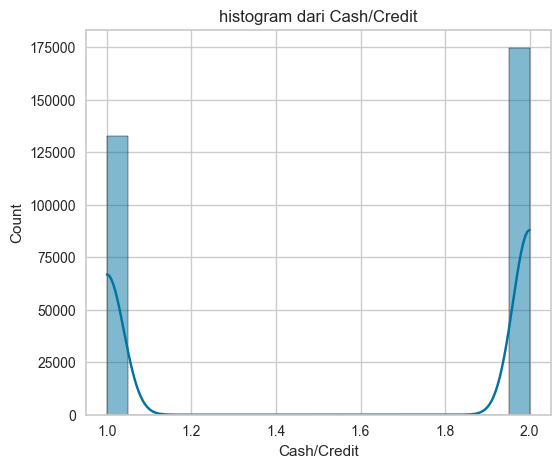

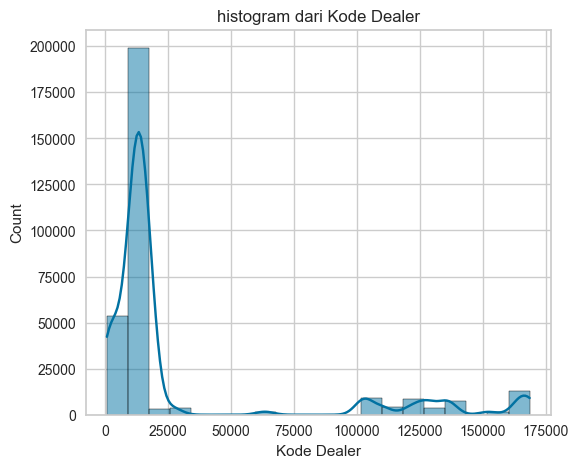

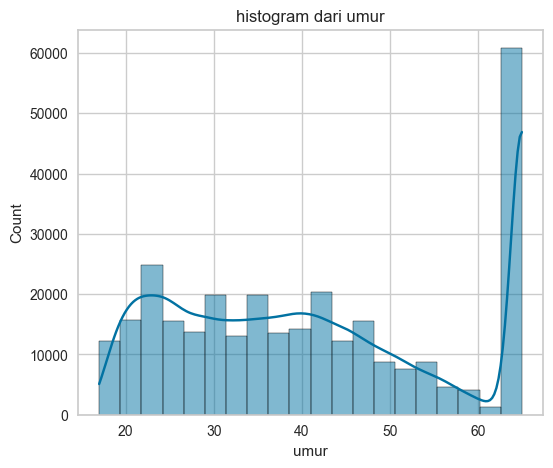

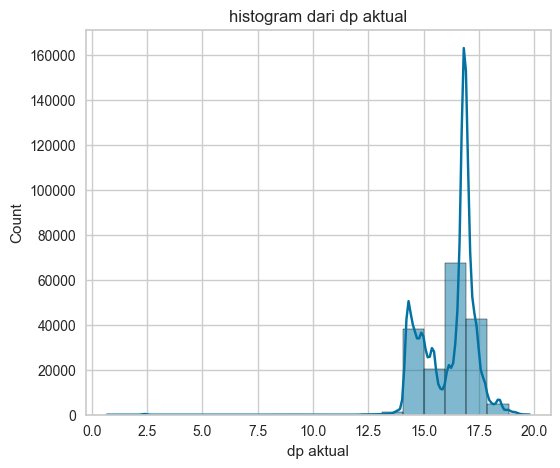

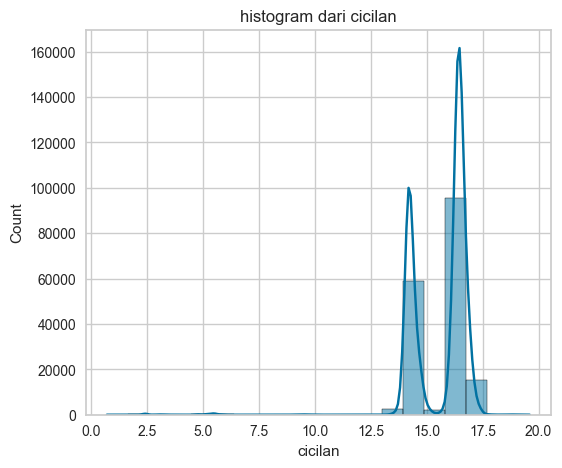

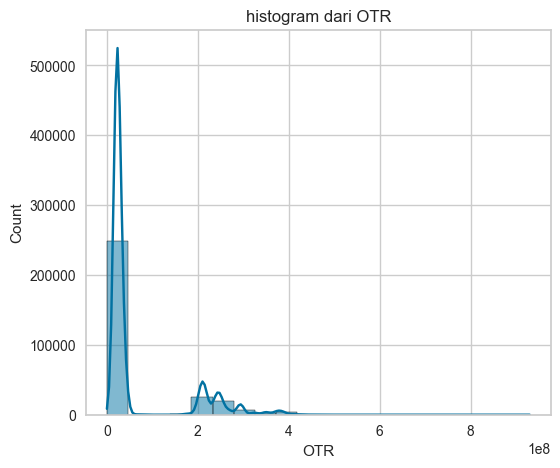

In [34]:
numerical_cols = df.select_dtypes(include=np.number).columns

for col in numerical_cols:
  plt.figure(figsize=(6,5))
  sns.histplot(df[col],kde=True,bins=20)
  plt.title(f'histogram dari {col}')
  plt.show()

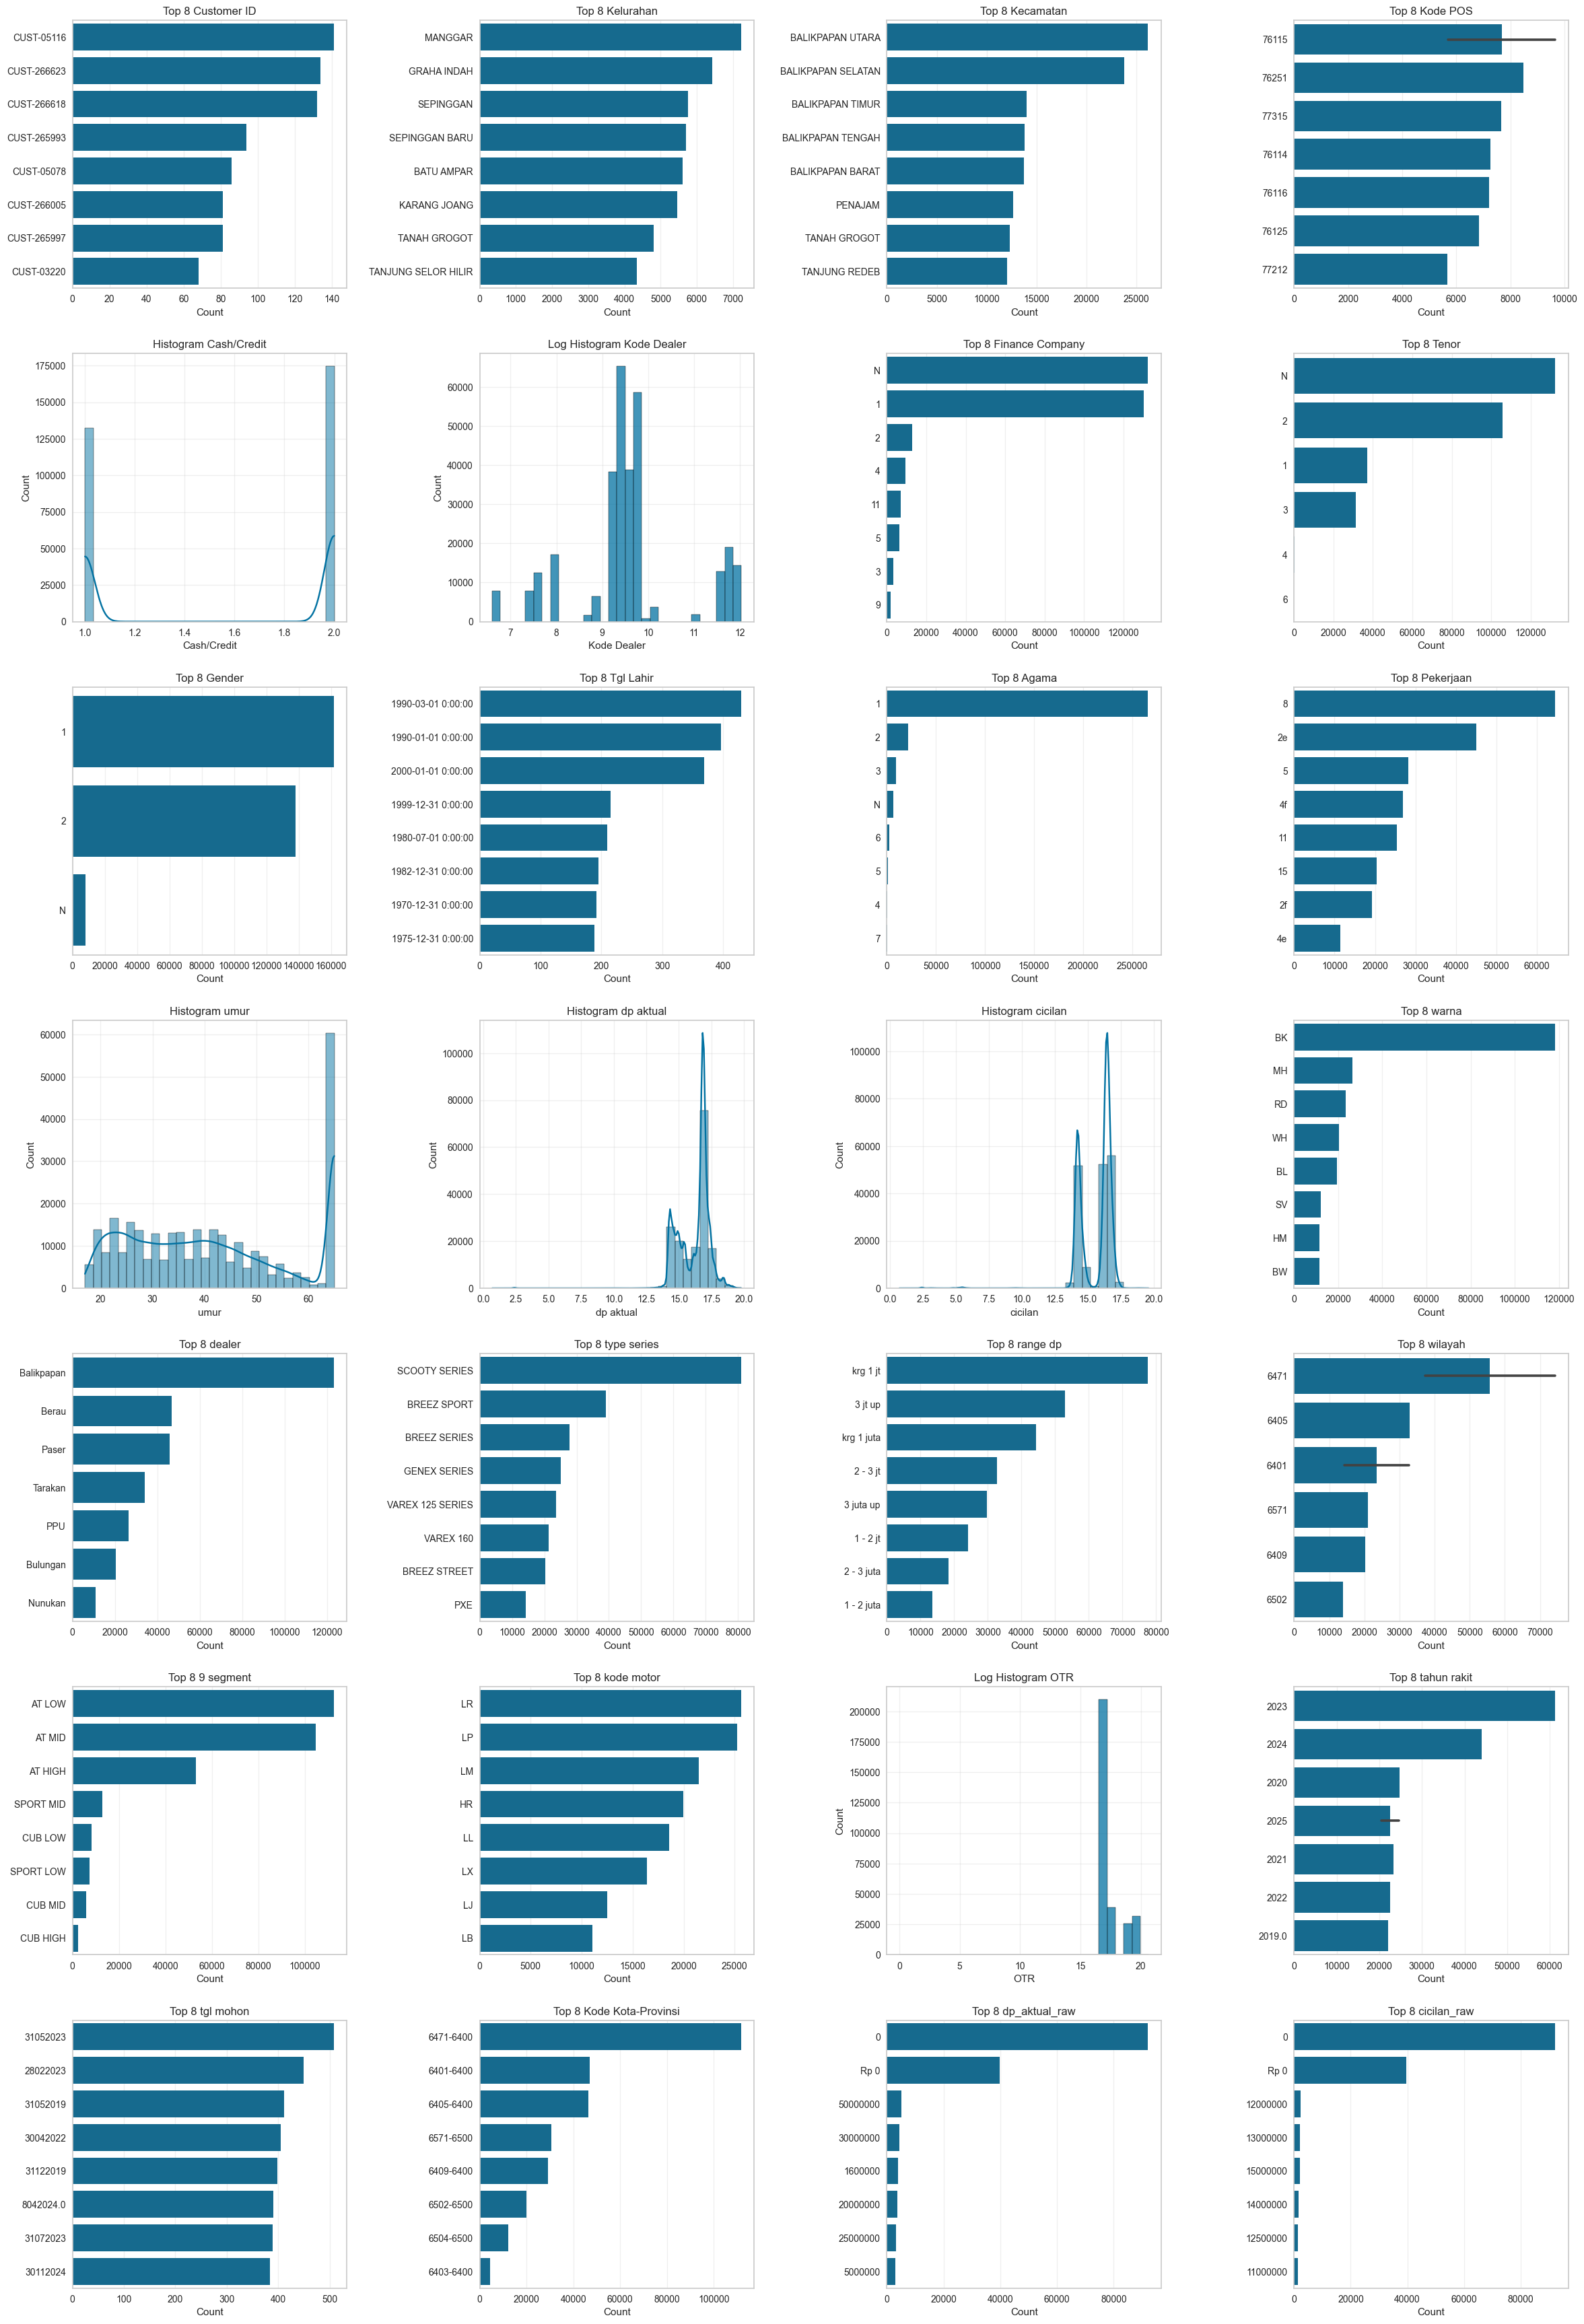

In [35]:
#Visualisasi distribusi fitur numerik dan kategorikal yang lebih informatif
numerical_cols = df.select_dtypes(include=['int64','float64']).columns
categorical_cols = df.select_dtypes(include=['object','category','string']).columns

all_cols = df.columns
n = len(all_cols)

# ==== Layout lebih proporsional ====
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                         figsize=(24, 5*nrows))

axes = axes.flatten()

for i, col in enumerate(all_cols):
    ax = axes[i]
    
    if col in numerical_cols:
        data = df[col].dropna()
        
        # Jika data sangat skewed, gunakan log scale
        if data.max() > 10 * data.median():
            sns.histplot(np.log1p(data), bins=30, ax=ax)
            ax.set_title(f"Log Histogram {col}")
        else:
            sns.histplot(data, bins=30, kde=True, ax=ax)
            ax.set_title(f"Histogram {col}")
        
        ax.grid(alpha=0.3)

    elif col in categorical_cols:
        vc = df[col].value_counts().nlargest(8)
        
        sns.barplot(x=vc.values, y=vc.index, ax=ax)
        ax.set_title(f"Top 8 {col}")
        ax.set_xlabel("Count")
        ax.set_ylabel("")
        ax.grid(axis='x', alpha=0.3)

    else:
        ax.set_visible(False)

# Hapus subplot kosong
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2)
plt.show()

### **Membuat Dataframe baru untuk klusterisasi label segmentasi prioritas follow up** 

#### Cek per fitur

In [36]:
df_labeling = df_agg.copy()
df_labeling = df_labeling[['Tenor', 'tahun rakit', 'dp aktual', 'cicilan', 'Cash/Credit' ,'OTR', 'Pekerjaan']]
df_labeling.head()

,Tenor,tahun rakit,dp aktual,cicilan,Cash/Credit,OTR,Pekerjaan
0,1.0,2021.0,16.949482,16.341239,2.0,22965000.0,4f
1,NaN,2022.0,NaN,NaN,1.0,36120000.0,N
2,NaN,2019.0,NaN,NaN,1.0,25785000.0,11
3,NaN,2025.0,NaN,NaN,1.0,25200000.0,N
4,NaN,2023.0,NaN,NaN,1.0,380700000.0,N


In [37]:
df_labeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184316 entries, 0 to 184371
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Tenor        107021 non-null  float64
 1   tahun rakit  184316 non-null  float64
 2   dp aktual    107358 non-null  float64
 3   cicilan      107354 non-null  float64
 4   Cash/Credit  184316 non-null  string 
 5   OTR          184316 non-null  float64
 6   Pekerjaan    184316 non-null  string 
dtypes: float64(5), string(2)
memory usage: 11.2 MB


##### Tenor

In [38]:
#cek jumlah data tiap tenor
print(df_labeling['Tenor'].value_counts())

Tenor
2.0    64905
1.0    21900
3.0    20139
4.0       75
6.0        2
Name: count, dtype: int64


In [39]:
#Menerapkan rule
#1 = ≤ 1 tahun
#2 = >1–2 tahun
#3 = > 2 tahun
conditions = [
    df_labeling['Tenor'] <= 1,
    (df_labeling['Tenor'] > 1) & (df_labeling['Tenor'] <= 2),
    df_labeling['Tenor'] > 2
]

choices = [1, 2, 3]

df_labeling['Tenor'] = np.select(conditions, choices)
print(df_labeling['Tenor'].value_counts())

Tenor
0    77295
2    64905
1    21900
3    20216
Name: count, dtype: int64


##### tahun rakit

In [40]:
print(df_labeling['tahun rakit'].value_counts())

tahun rakit
2025.0    38506
2024.0    29105
2023.0    28140
2019.0    27611
2022.0    26580
2021.0    19840
2020.0    14115
2018.0      414
2017.0        4
2026.0        1
Name: count, dtype: int64


##### dp aktual

In [41]:
print(df_labeling['dp aktual'].isna().sum())

76958


In [42]:
#outlier handling (capping) DP aktual
df_labeling['dp_aktual_raw'] = df_labeling['dp aktual']

df_dp = df_labeling[['dp aktual']].dropna().copy()

Q1 = df_dp['dp aktual'].quantile(0.25)
Q3 = df_dp['dp aktual'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_dp['dp_aktual_capped'] = df_dp['dp aktual'].clip(lower, upper)

df_labeling = df_labeling.merge(
    df_dp[['dp_aktual_capped']],
    left_index=True,
    right_index=True,
    how='left'
)

# ===============================
# 5. (Opsional) drop kolom lama jika perlu
    # ===============================
    # df_labeling = df_labeling.drop(columns=['dp aktual'])
    # df_labeling = df_labeling.rename(columns={'dp_aktual_capped': 'dp aktual'})

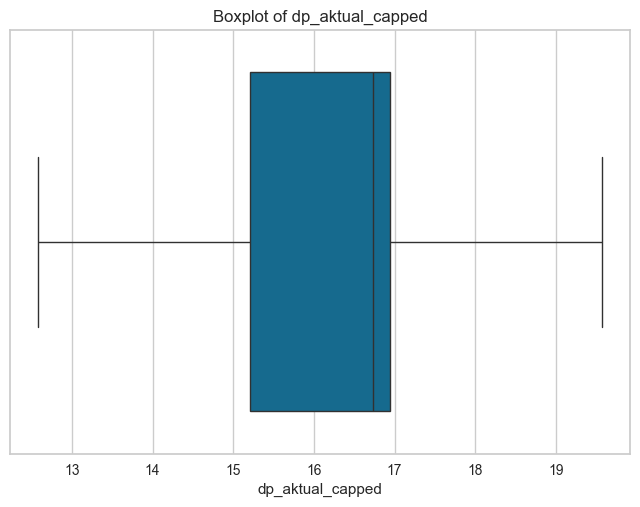

In [43]:
#boxplot

sns.boxplot(x='dp_aktual_capped', data=df_dp)
plt.title('Boxplot of dp_aktual_capped')
plt.show()

cicilan

In [44]:
print(df_labeling['cicilan'].isna().sum())

76962


In [45]:
#outlier handling (capping) DP aktual
df_labeling['cicilan_raw'] = df_labeling['cicilan']

df_dp = df_labeling[['cicilan']].dropna().copy()

Q1 = df_dp['cicilan'].quantile(0.25)
Q3 = df_dp['cicilan'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_dp['cicilan_capped'] = df_dp['cicilan'].clip(lower, upper)

df_labeling = df_labeling.merge(
    df_dp[['cicilan_capped']],
    left_index=True,
    right_index=True,
    how='left'
)

# ===============================
# 5. (Opsional) drop kolom lama jika perlu
    # ===============================
    # df_labeling = df_labeling.drop(columns=['cicilan'])

    # df_labeling = df_labeling.rename(columns={'cicilan_capped': 'cicilan'})

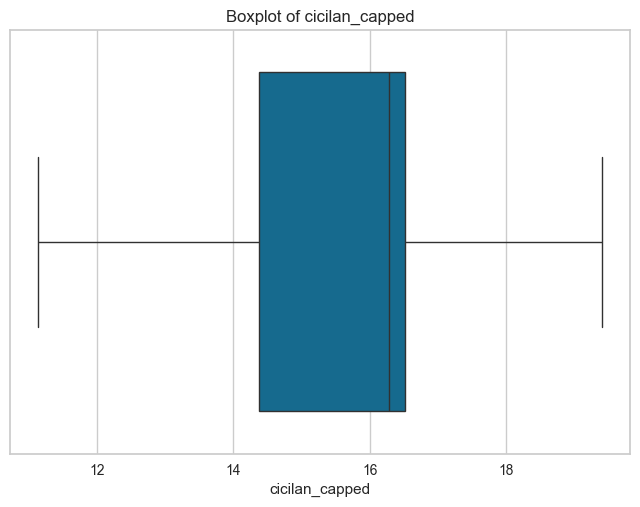

In [46]:
#boxplot

sns.boxplot(x='cicilan_capped', data=df_dp)
plt.title('Boxplot of cicilan_capped')
plt.show()

cash/credit

In [47]:
#cek jumlah data tiap cash/credit
print(df_labeling['Cash/Credit'].value_counts())

Cash/Credit
2.0    104758
1.0     79558
Name: count, dtype: Int64


OTR

In [48]:
df_labeling['OTR'].isna().sum()

np.int64(0)

In [49]:
df_labeling['OTR'].describe()

count    1.843160e+05
mean     6.040653e+07
std      8.564908e+07
min      0.000000e+00
25%      2.116000e+07
50%      2.331500e+07
75%      3.207000e+07
max      8.301000e+08
Name: OTR, dtype: float64

In [50]:
# =============================================================================
# BUSINESS RULE UNTUK FITUR OTR (Harga Kendaraan)
#
# - Nilai maksimum OTR sebesar 77.38 juta masih valid (kategori premium / big bike).
# - TIDAK dilakukan capping karena:
#     Jika dibatasi, maka segmen premium akan "turun" ke mid-range,
#     sehingga merusak struktur cluster yang ingin kita identifikasi.
# - Hanya dilakukan transformasi log1p untuk:
#     Mengurangi skewness ke kanan (right-skewed),
#     karena perbedaan harga motor budget vs premium sangat lebar.
# =============================================================================

# Gunakan copy agar tidak mengubah dataframe asli secara tidak sengaja
df = df.copy()

# Transformasi log1p pada kolom OTR
# log1p(x) = log(1 + x)
# Aman untuk nilai 0 dan membantu menstabilkan distribusi
df['OTR'] = np.log1p(df['OTR'])

# Cek distribusi setelah transformasi
print(df['OTR'].describe())

count    307101.000000
mean         17.422380
std           0.938756
min           0.000000
25%          16.872761
50%          16.988133
75%          17.365990
max          20.650803
Name: OTR, dtype: float64


## Pilih mau pake iqr apa transformasi log1p

In [51]:
#capping OTR
Q1 = df_labeling['OTR'].quantile(0.25)
Q3 = df_labeling['OTR'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_labeling['OTR'] = df_labeling['OTR'].clip(lower, upper)

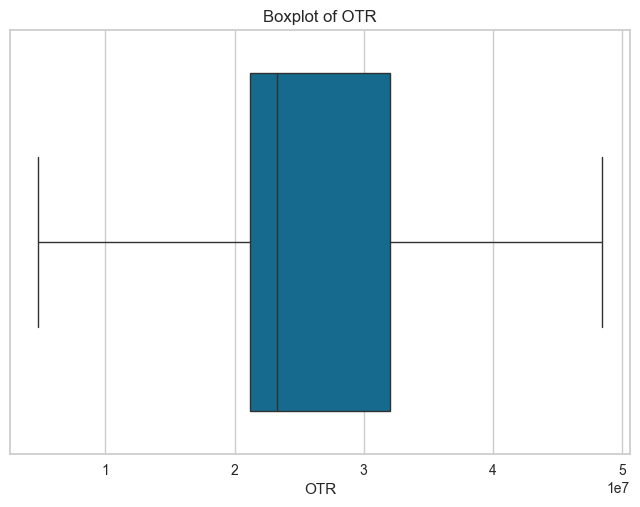

In [52]:
sns.boxplot(x='OTR', data=df_labeling)
plt.title('Boxplot of OTR')
plt.show()

Pekerjaan

In [53]:
df_labeling['Pekerjaan'].value_counts()

Pekerjaan
8     39703
2e    26383
5     18375
11    15568
4f    15510
15    12543
2f    11347
4e     6637
1      6610
2d     5195
2b     4511
2a     4170
6      3914
16     2483
N      2475
2c     2183
4a     2069
7      1690
3       780
4b      582
4d      570
12      501
4c      355
13       73
14       44
0        40
4         4
35        1
Name: count, dtype: Int64

In [54]:
#ubah value 11 menjadi N untuk Pekerjaan dan drop baris yang memiliki value 35 di Pekerjaan
df_labeling['Pekerjaan'] = (
    df_labeling['Pekerjaan']
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({'11': 'N'})
)

df_labeling = df_labeling[~df_labeling['Pekerjaan'].isin(['35','0'])].copy()


In [55]:
df_labeling['Pekerjaan'].value_counts()

Pekerjaan
8     39703
2E    26383
5     18375
N     18043
4F    15510
15    12543
2F    11347
4E     6637
1      6610
2D     5195
2B     4511
2A     4170
6      3914
16     2483
2C     2183
4A     2069
7      1690
3       780
4B      582
4D      570
12      501
4C      355
13       73
14       44
4         4
Name: count, dtype: int64

In [56]:
# Estimasi pendapatan bulanan (Rp) per sektor pekerjaan
income_map = {
    '1': 5000000,      # Pegawai Negeri
    '2': 4500000,      # Pegawai Swasta
    '2A': 3500000,
    '2B': 4500000,
    '2C': 4500000,
    '2D': 6000000,
    '2E': 4500000,
    '2F': 4000000,

    '3': 3000000,      # Ojek
    '4': 5000000,      # Wiraswasta
    '4A': 3500000,
    '4B': 5000000,
    '4C': 5000000,
    '4D': 6000000,
    '4E': 4500000,
    '4F': 4000000,

    '5': 1500000,      # Mahasiswa
    '6': 4500000,      # Guru/Dosen
    '7': 5500000,      # TNI/Polri
    '8': 2500000,      # IRT
    '9': 3000000,      # Petani/Nelayan
    '10': 8000000,     # Profesional
    '12': 9000000,     # Dokter
    '13': 9000000,     # Pengacara
    '14': 5000000,     # Wartawan
    '15': 3000000,     # Petani
    '16': 3000000,     # Nelayan
    'N': 3000000       # Lain-lain
}

In [57]:
#Buat fitur estimasi pendapatan
df_labeling['estimasi_pendapatan'] = (
    df_labeling['Pekerjaan']
    .astype(str)
    .str.upper()
    .map(income_map)
)

In [58]:
# Hitung IKB (Indeks Kemampuan Bayar) untuk mengukur kemampuan bayar pelanggan 
df_labeling['IKB'] = (
    (df_labeling['estimasi_pendapatan'] - df_labeling['cicilan']) /
    df_labeling['estimasi_pendapatan']
)

df_labeling['IKB'] = df_labeling['IKB'].clip(0, 1)

In [59]:
df_labeling['IKB'].isna().sum()

np.int64(76945)

### Labeling

Tenor, tahun rakit, cash/credit , dp aktual capped, cicilan capped, OTR, IKB

In [60]:
df_labeling[['Tenor', 'tahun rakit', 'Cash/Credit', 'dp_aktual_capped', 'cicilan_capped', 'OTR', 'IKB']].describe()

,Tenor,tahun rakit,dp_aktual_capped,cicilan_capped,OTR,IKB
count,184275.000000,184275.000000,107334.000000,107330.000000,1.842750e+05,107330.000000
mean,1.152148,2022.375607,16.230130,15.669029,2.808065e+07,0.999995
std,1.089540,2.079035,1.106568,1.115956,1.017155e+07,0.000002
min,0.000000,2017.000000,12.581924,11.142456,4.795000e+06,0.999987
25%,0.000000,2021.000000,15.201805,14.371119,2.116000e+07,0.999994
50%,1.000000,2023.000000,16.735441,16.283610,2.331500e+07,0.999996
75%,2.000000,2024.000000,16.948393,16.523561,3.207000e+07,0.999996
max,3.000000,2026.000000,19.568274,19.401635,4.843500e+07,1.000000


In [61]:
df_labeling.shape

(184275, 13)

In [62]:
df_labeling.isna().sum()

Tenor                      0
tahun rakit                0
dp aktual              76941
cicilan                76945
Cash/Credit                0
OTR                        0
Pekerjaan                  0
dp_aktual_raw          76941
dp_aktual_capped       76941
cicilan_raw            76945
cicilan_capped         76945
estimasi_pendapatan        0
IKB                    76945
dtype: int64

In [63]:
df_labeling['Tenor'].unique()

array([1, 0, 2, 3])

In [64]:
# Feature turunan
df_labeling['vehicle_age'] = 2026 - df_labeling['tahun rakit']
df_labeling['dp_ratio'] = df_labeling['dp_aktual_capped'] / df_labeling['OTR']
df_labeling['cicilan_ratio'] = df_labeling['cicilan_capped'] / df_labeling['OTR']

# Threshold distribusi
ikb_q75 = df_labeling['IKB'].quantile(0.75)
ikb_q50 = df_labeling['IKB'].quantile(0.50)
otr_low = df_labeling['OTR'].quantile(0.25)
age_old = df_labeling['vehicle_age'].quantile(0.60)

# Scoring (dengan PENALTI eksplisit)
score = np.zeros(len(df_labeling))

# Bonus: IKB tinggi
score += np.where(df_labeling['IKB'] >= ikb_q75, 2, 0)
score += np.where(df_labeling['IKB'].between(ikb_q50, ikb_q75), 1, 0)

# Bonus: Tenor pendek
score += np.where(df_labeling['Tenor'] == 2, 1, 0)

# Bonus: Usia kendaraan tua (upgrade potential)
score += np.where(df_labeling['vehicle_age'] >= age_old, 1, 0)

# Bonus: Beban cicilan ringan
score += np.where(df_labeling['cicilan_ratio'] <= df_labeling['cicilan_ratio'].median(), 1, 0)

# Bonus: Cash exception (upgrade cepat)
score += np.where(
    (df_labeling['Cash/Credit'] == '1') & (df_labeling['OTR'] <= otr_low),
    1, 0
)

# PENALTI (FIX UTAMA)

# Penalti: IKB buruk (≤ median)
score -= np.where(df_labeling['IKB'] <= ikb_q50, 2, 0)

# Penalti: DP terlalu besar (> 100% OTR, tidak masuk akal)
score -= np.where(df_labeling['dp_ratio'] > 1.0, 2, 0)

# Penalti: Tenor panjang (3 = cicilan 36 bulan)
score -= np.where(df_labeling['Tenor'] == 3, 1, 0)

# Penalti: Beban cicilan berat (> quantile 75)
score -= np.where(
    df_labeling['cicilan_ratio'] > df_labeling['cicilan_ratio'].quantile(0.75), 
    1, 0
)

df_labeling['score'] = score

# Mapping ke label (kontrol proporsi)
high_cut = df_labeling['score'].quantile(0.90)    # ~10%
med_cut  = df_labeling['score'].quantile(0.70)    # ~20%

df_labeling['priority_label'] = np.where(
    df_labeling['score'] >= high_cut, 'High',
    np.where(df_labeling['score'] >= med_cut, 'Medium', 'Low')
)

# HARD GATE untuk High (WAJIB)
eligible_high = (
    (df_labeling['IKB'] >= ikb_q75) &
    (df_labeling['cicilan_ratio'] <= df_labeling['cicilan_ratio'].quantile(0.50)) &
    (df_labeling['Tenor'].isin([1, 2])) &
    (df_labeling['dp_ratio'] <= 1.0)
)

# Downgrade High yang tidak eligible
df_labeling.loc[
    ~eligible_high & (df_labeling['priority_label'] == 'High'),
    'priority_label'
] = 'Medium'

print("="*60)
print("DISTRIBUSI LABEL (setelah penalti + hard gate)")
print("="*60)
print(df_labeling['priority_label'].value_counts(normalize=True))
print("\n")
print(df_labeling['priority_label'].value_counts())

DISTRIBUSI LABEL (setelah penalti + hard gate)
priority_label
Low       0.497875
Medium    0.441178
High      0.060947
Name: proportion, dtype: float64


priority_label
Low       91746
Medium    81298
High      11231
Name: count, dtype: int64


In [65]:
#Sanity check
cols_check = [
    'Tenor', 'tahun rakit', 'vehicle_age',
    'Cash/Credit', 'dp_aktual_capped', 'cicilan_capped',
    'dp_ratio', 'cicilan_ratio', 'OTR', 'IKB', 'score'
]

for lbl in ['High', 'Medium', 'Low']:
    print(f"\n{'='*20} {lbl} {'='*20}")
    display(
        df_labeling[df_labeling['priority_label'] == lbl]
        .sample(10, random_state=42)
        [cols_check]
    )


==================== High ====================


,Tenor,tahun rakit,vehicle_age,Cash/Credit,dp_aktual_capped,cicilan_capped,dp_ratio,cicilan_ratio,OTR,IKB,score
174288,2,2024.0,2.0,2.0,14.946913,14.508658,4.883016e-07,4.739843e-07,30610000.0,0.999998,4.0
37142,2,2024.0,2.0,2.0,14.457365,14.333114,5.732500e-07,5.683233e-07,25220000.0,0.999997,4.0
167242,1,2024.0,2.0,2.0,14.819446,14.962913,4.854060e-07,4.901053e-07,30530000.0,0.999997,3.0
25708,2,2024.0,2.0,2.0,14.457365,14.503646,5.526516e-07,5.544207e-07,26160000.0,0.999997,4.0
125805,1,2025.0,1.0,2.0,15.424949,14.648420,5.962485e-07,5.662319e-07,25870000.0,0.999998,3.0
140198,1,2020.0,6.0,2.0,17.287166,16.567259,5.370353e-07,5.146710e-07,32190000.0,0.999997,4.0
24725,2,2025.0,1.0,2.0,14.808763,14.346139,5.637138e-07,5.461035e-07,26270000.0,0.999997,4.0
25058,2,2025.0,1.0,2.0,14.457365,14.379688,5.503375e-07,5.473806e-07,26270000.0,0.999997,4.0
110505,2,2025.0,1.0,2.0,14.978662,14.665662,4.827155e-07,4.726285e-07,31030000.0,0.999997,4.0
26036,2,2024.0,2.0,2.0,15.830414,14.590238,4.040432e-07,3.723899e-07,39180000.0,0.999997,4.0



==================== Medium ====================


,Tenor,tahun rakit,vehicle_age,Cash/Credit,dp_aktual_capped,cicilan_capped,dp_ratio,cicilan_ratio,OTR,IKB,score
27959,3,2024.0,2.0,2.0,14.946913,14.359578,4.929721e-07,4.736009e-07,30320000.0,0.999997,2.0
148550,2,2024.0,2.0,2.0,15.424949,14.594836,4.291861e-07,4.060889e-07,35940000.0,0.999996,3.0
122075,0,2020.0,6.0,1.0,NaN,NaN,NaN,NaN,18395000.0,NaN,1.0
138673,3,2024.0,2.0,2.0,14.285515,13.997833,6.388871e-07,6.260212e-07,22360000.0,0.999997,2.0
171457,0,2020.0,6.0,1.0,NaN,NaN,NaN,NaN,21520000.0,NaN,1.0
73457,2,2023.0,3.0,2.0,18.315320,16.694709,3.781423e-07,3.446828e-07,48435000.0,0.999996,3.0
32835,0,2019.0,7.0,1.0,NaN,NaN,NaN,NaN,21625000.0,NaN,1.0
48325,2,2019.0,7.0,2.0,16.713079,16.403275,9.218466e-07,9.047587e-07,18130000.0,0.999996,2.0
14933,1,2022.0,4.0,2.0,16.950570,16.479261,7.373019e-07,7.168012e-07,22990000.0,0.999996,2.0
165521,0,2019.0,7.0,1.0,NaN,NaN,NaN,NaN,22130000.0,NaN,1.0



==================== Low ====================


,Tenor,tahun rakit,vehicle_age,Cash/Credit,dp_aktual_capped,cicilan_capped,dp_ratio,cicilan_ratio,OTR,IKB,score
62257,3,2025.0,1.0,2.0,14.430697,14.187075,5.726467e-07,5.629792e-07,25200000.0,0.999995,-2.0
165622,1,2022.0,4.0,2.0,16.871397,16.237655,7.943219e-07,7.644847e-07,21240000.0,0.999995,-1.0
27111,3,2025.0,1.0,2.0,14.285515,14.017636,8.309880e-07,8.154055e-07,17191000.0,0.999997,0.0
142423,3,2020.0,6.0,2.0,16.903138,16.108045,7.709527e-07,7.346885e-07,21925000.0,0.999994,-2.0
81419,0,2024.0,2.0,1.0,NaN,NaN,NaN,NaN,39230000.0,NaN,0.0
73466,2,2024.0,2.0,2.0,14.285515,14.245994,6.337850e-07,6.320317e-07,22540000.0,0.999995,0.0
146514,1,2021.0,5.0,2.0,16.964608,16.666217,7.276263e-07,7.148281e-07,23315000.0,0.999993,-1.0
32622,2,2023.0,3.0,2.0,18.064006,16.474371,3.729536e-07,3.401336e-07,48435000.0,0.999993,0.0
136786,0,2025.0,1.0,1.0,NaN,NaN,NaN,NaN,20734000.0,NaN,0.0
147972,0,2025.0,1.0,1.0,NaN,NaN,NaN,NaN,34270000.0,NaN,0.0


In [66]:
#Sanity check - Fokus ke High Priority
cols_check = [
    'Tenor', 'vehicle_age', 'Cash/Credit',
    'dp_ratio', 'cicilan_ratio', 'IKB', 'score', 'priority_label'
]

print("="*80)
print("SANITY CHECK: 15 SAMPLE HIGH PRIORITY (harus bersih)")
print("="*80)
print("\nKriteria High yang BENAR:")
print("  ✓ IKB >= Q75 (tinggi, bukan 0)")
print("  ✓ Tenor = 1 atau 2 (pendek)")
print("  ✓ cicilan_ratio <= median (beban ringan)")
print("  ✓ dp_ratio <= 1.0 (wajar)")
print("\n")

high_sample = df_labeling[df_labeling['priority_label'] == 'High'].sample(15, random_state=42)
display(high_sample[cols_check])

# Validasi otomatis
print("\n" + "="*80)
print("VALIDASI OTOMATIS HIGH")
print("="*80)
high_df = df_labeling[df_labeling['priority_label'] == 'High']
print(f"Total High: {len(high_df):,}")
print(f"IKB mean: {high_df['IKB'].mean():.3f} (harus > 0.5)")
print(f"IKB min: {high_df['IKB'].min():.3f} (harus > 0)")
print(f"Tenor mode: {high_df['Tenor'].mode().values[0]} (harus 1 atau 2)")
print(f"dp_ratio max: {high_df['dp_ratio'].max():.3f} (harus <= 1.0)")
print(f"cicilan_ratio mean: {high_df['cicilan_ratio'].mean():.3f}")

# Hitung anomali (kalau masih ada)
anomali_ikb = (high_df['IKB'] <= 0.3).sum()
anomali_tenor = (~high_df['Tenor'].isin([1, 2])).sum()
anomali_dp = (high_df['dp_ratio'] > 1.0).sum()

print(f"\n⚠️  Anomali di High:")
print(f"  - IKB <= 0.3: {anomali_ikb}")
print(f"  - Tenor bukan 1/2: {anomali_tenor}")
print(f"  - DP ratio > 1.0: {anomali_dp}")

if anomali_ikb + anomali_tenor + anomali_dp == 0:
    print("\n✅ HIGH PRIORITY BERSIH - SIAP PRODUKSI")
else:
    print("\n❌ MASIH ADA ANOMALI - PERLU FIX LAGI")

SANITY CHECK: 15 SAMPLE HIGH PRIORITY (harus bersih)

Kriteria High yang BENAR:
  ✓ IKB >= Q75 (tinggi, bukan 0)
  ✓ Tenor = 1 atau 2 (pendek)
  ✓ cicilan_ratio <= median (beban ringan)
  ✓ dp_ratio <= 1.0 (wajar)




,Tenor,vehicle_age,Cash/Credit,dp_ratio,cicilan_ratio,IKB,score,priority_label
174288,2,2.0,2.0,4.883016e-07,4.739843e-07,0.999998,4.0,High
37142,2,2.0,2.0,5.732500e-07,5.683233e-07,0.999997,4.0,High
167242,1,2.0,2.0,4.854060e-07,4.901053e-07,0.999997,3.0,High
25708,2,2.0,2.0,5.526516e-07,5.544207e-07,0.999997,4.0,High
125805,1,1.0,2.0,5.962485e-07,5.662319e-07,0.999998,3.0,High
140198,1,6.0,2.0,5.370353e-07,5.146710e-07,0.999997,4.0,High
24725,2,1.0,2.0,5.637138e-07,5.461035e-07,0.999997,4.0,High
25058,2,1.0,2.0,5.503375e-07,5.473806e-07,0.999997,4.0,High
110505,2,1.0,2.0,4.827155e-07,4.726285e-07,0.999997,4.0,High
26036,2,2.0,2.0,4.040432e-07,3.723899e-07,0.999997,4.0,High



VALIDASI OTOMATIS HIGH
Total High: 11,231
IKB mean: 1.000 (harus > 0.5)
IKB min: 1.000 (harus > 0)
Tenor mode: 2 (harus 1 atau 2)
dp_ratio max: 0.000 (harus <= 1.0)
cicilan_ratio mean: 0.000

⚠️  Anomali di High:
  - IKB <= 0.3: 0
  - Tenor bukan 1/2: 0
  - DP ratio > 1.0: 0

✅ HIGH PRIORITY BERSIH - SIAP PRODUKSI


Modeling

In [67]:
df_labeling.head()

,Tenor,tahun rakit,dp aktual,cicilan,Cash/Credit,OTR,Pekerjaan,dp_aktual_raw,dp_aktual_capped,cicilan_raw,cicilan_capped,estimasi_pendapatan,IKB,vehicle_age,dp_ratio,cicilan_ratio,score,priority_label
0,1,2021.0,16.949482,16.341239,2.0,22965000.0,4F,16.949482,16.949482,16.341239,16.341239,4000000,0.999996,5.0,7.380571e-07,7.115715e-07,2.0,Medium
1,0,2022.0,NaN,NaN,1.0,36120000.0,N,NaN,NaN,NaN,NaN,3000000,NaN,4.0,NaN,NaN,1.0,Medium
2,0,2019.0,NaN,NaN,1.0,25785000.0,N,NaN,NaN,NaN,NaN,3000000,NaN,7.0,NaN,NaN,1.0,Medium
3,0,2025.0,NaN,NaN,1.0,25200000.0,N,NaN,NaN,NaN,NaN,3000000,NaN,1.0,NaN,NaN,0.0,Low
4,0,2023.0,NaN,NaN,1.0,48435000.0,N,NaN,NaN,NaN,NaN,3000000,NaN,3.0,NaN,NaN,0.0,Low


In [68]:
df_labeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184275 entries, 0 to 184371
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Tenor                184275 non-null  int64  
 1   tahun rakit          184275 non-null  float64
 2   dp aktual            107334 non-null  float64
 3   cicilan              107330 non-null  float64
 4   Cash/Credit          184275 non-null  string 
 5   OTR                  184275 non-null  float64
 6   Pekerjaan            184275 non-null  object 
 7   dp_aktual_raw        107334 non-null  float64
 8   dp_aktual_capped     107334 non-null  float64
 9   cicilan_raw          107330 non-null  float64
 10  cicilan_capped       107330 non-null  float64
 11  estimasi_pendapatan  184275 non-null  int64  
 12  IKB                  107330 non-null  float64
 13  vehicle_age          184275 non-null  float64
 14  dp_ratio             107334 non-null  float64
 15  cicilan_ratio        1

In [69]:
#feature engineering untuk model
df_final = df_labeling.copy()
df_final.drop(columns=['tahun rakit', 'dp aktual', 'cicilan','cicilan_raw','cicilan_capped', 'OTR', 'Pekerjaan', 'dp_aktual_raw', 'dp_aktual_capped', 'estimasi_pendapatan'], inplace=True)

#mapping priority_label ke angka untuk modeling
label_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df_final['priority_label'] = df_final['priority_label'].map(label_mapping)
df_final.head()

,Tenor,Cash/Credit,IKB,vehicle_age,dp_ratio,cicilan_ratio,score,priority_label
0,1,2.0,0.999996,5.0,7.380571e-07,7.115715e-07,2.0,1
1,0,1.0,NaN,4.0,NaN,NaN,1.0,1
2,0,1.0,NaN,7.0,NaN,NaN,1.0,1
3,0,1.0,NaN,1.0,NaN,NaN,0.0,0
4,0,1.0,NaN,3.0,NaN,NaN,0.0,0


In [70]:
X = df_final.drop(columns=['priority_label'])
y = df_final['priority_label']

In [71]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
scalers = {}
df_scaled = X.copy()

for col in numerical_cols:
    scaler = MinMaxScaler()
    df_scaled[col] = scaler.fit_transform(X[[col]])

# melakukan encoding pada kolom kategori
categorical_cols = X.select_dtypes(include=['object', 'string']).columns
encoders = {}
df_encoded = df_scaled.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le
    
# menambahkan kembali kolom target
df_encoded['Target'] = y
df_encoded.head()

,Tenor,Cash/Credit,IKB,vehicle_age,dp_ratio,cicilan_ratio,score,Target
0,0.333333,1,0.700132,0.555556,0.460618,0.460931,0.6,1
1,0.000000,0,NaN,0.444444,NaN,NaN,0.5,1
2,0.000000,0,NaN,0.777778,NaN,NaN,0.5,1
3,0.000000,0,NaN,0.111111,NaN,NaN,0.4,0
4,0.000000,0,NaN,0.333333,NaN,NaN,0.4,0


In [72]:
# Menggunakan train_test_split() untuk melakukan pembagian dataset.
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['Target']), df_encoded['Target'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((128992, 7), (55283, 7), (128992,), (55283,))

In [73]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("Presisi: ", precision_score(y_test, y_pred, average='weighted'))
print("Recall: ", recall_score(y_test,y_pred, average='weighted'))
print("f1-score: ", f1_score(y_test,y_pred, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Akurasi: 1.0
Presisi:  1.0
Recall:  1.0
f1-score:  1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27591
           1       1.00      1.00      1.00     24416
           2       1.00      1.00      1.00      3276

    accuracy                           1.00     55283
   macro avg       1.00      1.00      1.00     55283
weighted avg       1.00      1.00      1.00     55283



In [74]:
#simpan model 
joblib.dump(model, 'customer_priority_model.pkl')

['customer_priority_model.pkl']